# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

 Number of reviews: 568,454                                                                                                     
 Number of users: 256,059                                                                                                       
 Number of products: 74,258                                                                                                                                                                                                             
 Number of Attributes/Columns in data: 10
 
 Attributes:
1. IdRow Id
2. ProductIdUnique identifier for the product
3. UserIdUnqiue identifier for the user
4. ProfileNameProfile name of the user
5. HelpfulnessNumeratorNumber of users who found the review helpful
6. HelpfulnessDenominatorNumber of users who indicated whether they found the review helpful
7. ScoreRating between 1 and 5
8. TimeTimestamp for the review
9. SummaryBrief summary of the review
10. TextText of the review

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import pickle

In [8]:
# Loading 250 pts obtained after data preprocessing and sorting 

with open('C:/Users/U6069188/Python Projects/Pickle/FilteredData_250K','rb') as f:
    FilteredData = pickle.load(f)

In [9]:
FilteredData = FilteredData.head(100000)

FilteredData["Score"].value_counts()

positive    85197
negative    14803
Name: Score, dtype: int64

In [10]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "positive":
        return 1
    else:
        return -1

FilteredData["Score"] = FilteredData["Score"].map(polarity)

FilteredData["Score"].value_counts()

 1    85197
-1    14803
Name: Score, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(FilteredData['CleanedText'].values, FilteredData['Score'].values, train_size=.7)

In [12]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(6370,) (6363,)
(12733,) (6363,)
(19096,) (6363,)
(25459,) (6363,)
(31822,) (6363,)
(38185,) (6363,)
(44548,) (6363,)
(50911,) (6363,)
(57274,) (6363,)
(63637,) (6363,)


In [13]:
from sklearn.datasets import *
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score,log_loss
from sklearn.linear_model import SGDClassifier
import pandas as pd
import seaborn as sns       
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint as sp_randint
import graphviz 
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus
from IPython.display import Image
import xgboost as xgb
from wordcloud import WordCloud

def RunRandomForest_CV(X_train, y_train):
    g = sp_randint(2,100)
    #sorted(g.rvs(30))
    params = {'n_estimators' : list(np.arange(10,100,10))}
    model_grid = GridSearchCV(RandomForestClassifier(),param_grid = params,cv=10,scoring='f1')
    model_grid.fit(X_train, y_train)
    
    print(model_grid.best_estimator_)
    basemodelcount = list(model_grid.best_estimator_.get_params().items())[11]
    print(basemodelcount)
    mean_test_scores = model_grid.cv_results_['mean_test_score']
    MSE = [1 - x for x in mean_test_scores]
    
    # plot misclassification error vs depth
    plt.plot(params['n_estimators'], MSE, marker = '*') 

    plt.title("Misclassification Error vs No of Base models")
    plt.xlabel('Base models')
    plt.ylabel('Misclassification Error')
    plt.show()
    d
    return basemodelcount[1]
    
def RunXGBoost_CV(X_train, y_train):
    params = {'n_estimators' : list(np.arange(10,100,10)),
               'max_depth' : [1,2,3,5,7]}
    
    model_grid = GridSearchCV(xgb.XGBClassifier(),param_grid = params,cv=10,scoring='f1')
    model_grid.fit(X_train, y_train)
    
    print(model_grid.best_estimator_)
    
    pvt = pd.pivot_table(pd.DataFrame(model_grid.cv_results_),values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
    
    ax = sns.heatmap(pvt,annot=True)
    
    basemodelcount = list(model_grid.best_estimator_.get_params().items())[10]
    maxdepth = list(model_grid.best_estimator_.get_params().items())[7]
    return basemodelcount[1],maxdepth[1]

def Run_RandomForestDT(X_train, y_train,X_test,y_test,basemodelcount):
    
    model = RandomForestClassifier(n_estimators = basemodelcount);
    
    model.fit(X_train, y_train)
    
    predictions_proba = model.predict_proba(X_test)
    pred = model.predict(X_test)
    
    log_loss_score = log_loss(y_test, predictions_proba)
    #Accuracy on train data
    train_acc = model.score(X_train, y_train)
    train_err = 1-train_acc
        
    #Accuracy on test data
    test_acc = accuracy_score(y_test, pred)*100
    test_err = 1- test_acc
        
    print('*'*120)
    print('Base Model count is' ,basemodelcount)
    print('Accuracy is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('Log loss: %.5f' % log_loss_score)
    print('F1 score is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report is \n ' , classification_report(y_test,pred))
    
    cm= confusion_matrix(y_test, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return train_err,test_err,model

def Run_XGBoostDT(X_train, y_train,X_test,y_test,basemodelcount,maxdepth):
    
    model = xgb.XGBClassifier(n_estimators = basemodelcount,max_depth = maxdepth);
    
    model.fit(X_train, y_train)
    
    predictions_proba = model.predict_proba(X_test)
    pred = model.predict(X_test)
    
    log_loss_score = log_loss(y_test, predictions_proba)
    #Accuracy on train data
    train_acc = model.score(X_train, y_train)
    train_err = 1-train_acc
        
    #Accuracy on test data
    test_acc = accuracy_score(y_test, pred)*100
    test_err = 1- test_acc
        
    print('*'*120)
    print('Base Model count is' ,basemodelcount)
    print('Accuracy is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('Log loss: %.5f' % log_loss_score)
    print('F1 score is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report is \n ' , classification_report(y_test,pred))
    
    cm= confusion_matrix(y_test, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return train_err,test_err,model

def Tree(X_train, y_train,bow,name) :
    model = DecisionTreeClassifier(class_weight='balanced',max_depth = 3)
    model.fit(X_train, y_train)
    
    dot_data = StringIO()
    tree.export_graphviz(model,out_file=dot_data,feature_names=bow.get_feature_names(),class_names=np.array(['positive','negative']),filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(name)
    
def feature_importance(model,features):
    # Calculate feature importances from decision trees
    importances = model.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1][:15]
    
    features = np.array(features)
    cloud = WordCloud(width=1440, height=1080).generate(" ".join(features[indices]))
    plt.figure(figsize=(7, 7))
    plt.imshow(cloud)
    plt.axis('off')

    # Show plot
    plt.show()

# BOW

In [11]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn import preprocessing

bow = CountVectorizer(binary = True).fit(X_train)

In [12]:
X_train_bow = bow.transform(X_train)
X_train_bow.shape

(70000, 31893)

In [13]:
X_test_bow = bow.transform(X_test)

# RandomForestClassifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
('n_estimators', 30)


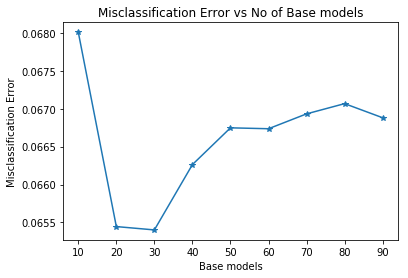

In [19]:
basemodelcount_RF_bow = RunRandomForest_CV(X_train_bow, y_train)

************************************************************************************************************************
Base Model count is 30
Accuracy is  88.28
Log loss: 0.30423
F1 score is  64.99
Recall is  61.22
Precision is  88.31

 Classification report is 
                precision    recall  f1-score   support

          -1       0.88      0.23      0.36      4391
           1       0.88      0.99      0.94     25609

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.88      0.61      0.65     30000
weighted avg       0.88      0.88      0.85     30000



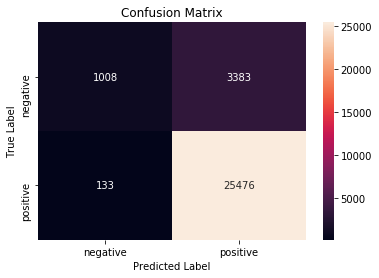

In [20]:
train_err_RF_bow,test_err_RF_bow,model_RF_bow = Run_RandomForestDT(X_train_bow, y_train,X_test_bow,y_test,basemodelcount_RF_bow)

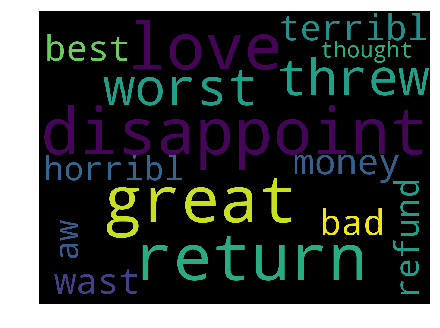

In [21]:
feature_importance(model_RF_bow,bow.get_feature_names())

# XGBoostClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


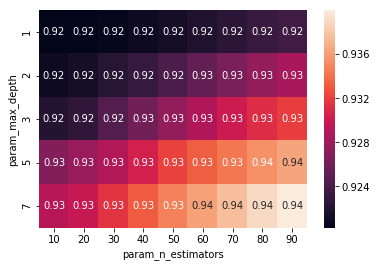

In [14]:
basemodelcount_XG_bow, max_depth_XG_bow = RunXGBoost_CV(X_train_bow, y_train)

************************************************************************************************************************
Base Model count is 90
Accuracy is  89.17
Log loss: 0.26526
F1 score is  70.23
Recall is  65.44
Precision is  88.3

 Classification report is 
                precision    recall  f1-score   support

          -1       0.87      0.32      0.46      4457
           1       0.89      0.99      0.94     25543

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.88      0.65      0.70     30000
weighted avg       0.89      0.89      0.87     30000



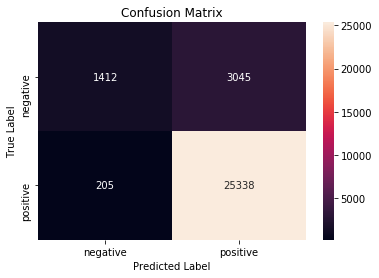

In [15]:
train_err_XG_bow,test_err_XG_bow,model_XG_bow = Run_XGBoostDT(X_train_bow, y_train,X_test_bow,y_test,basemodelcount_XG_bow, max_depth_XG_bow)

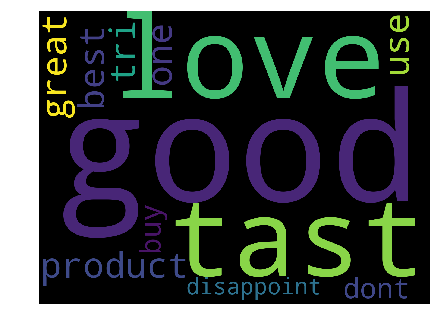

In [16]:
feature_importance(model_XG_bow,bow.get_feature_names())

# Tf-Idf

In [14]:
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df = 5).fit(X_train)

In [15]:
X_train_tfidf = tfidf.transform(X_train)

In [16]:
X_test_tfidf= tfidf.transform(X_test)

In [17]:
X_train_tfidf.shape

(70000, 91033)

In [18]:
X_test_tfidf.shape

(30000, 91033)

# RandomForestClassifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
('n_estimators', 10)


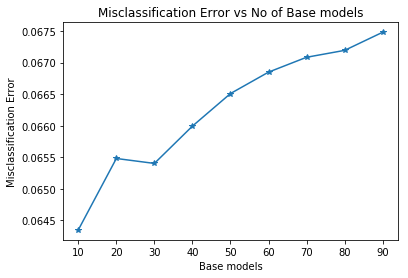

In [27]:
basemodelcount_RF_tfidf = RunRandomForest_CV(X_train_tfidf, y_train)

************************************************************************************************************************
Base Model count is 10
Accuracy is  88.61
Log loss: 0.61826
F1 score is  68.7
Recall is  64.43
Precision is  84.07

 Classification report is 
                precision    recall  f1-score   support

          -1       0.79      0.30      0.44      4391
           1       0.89      0.99      0.94     25609

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.84      0.64      0.69     30000
weighted avg       0.88      0.89      0.86     30000



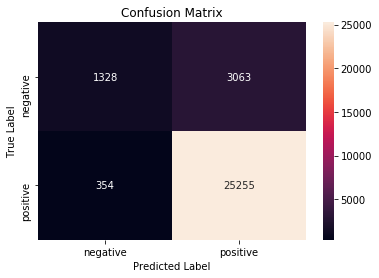

In [28]:
train_err_RF_tfidf,test_err_RF_tfidf,model_RF_tfidf = Run_RandomForestDT(X_train_tfidf, y_train,X_test_tfidf,y_test,basemodelcount_RF_tfidf)

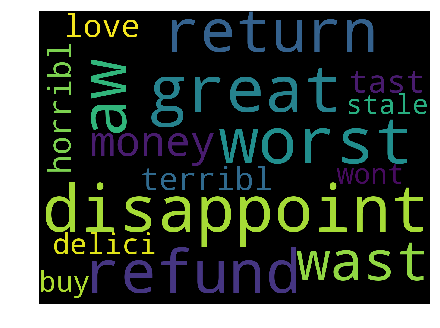

In [29]:
feature_importance(model_RF_tfidf,tfidf.get_feature_names())

# XGBoostClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


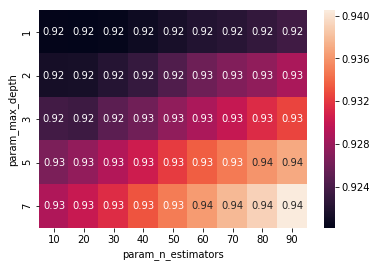

In [19]:
basemodelcount_XG_tfidf, max_depth_XG_tfidf = RunXGBoost_CV(X_train_tfidf, y_train)

************************************************************************************************************************
Base Model count is 90
Accuracy is  89.36
Log loss: 0.25799
F1 score is  70.71
Recall is  65.82
Precision is  88.56

 Classification report is 
                precision    recall  f1-score   support

          -1       0.88      0.32      0.47      4423
           1       0.89      0.99      0.94     25577

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.89      0.66      0.71     30000
weighted avg       0.89      0.89      0.87     30000



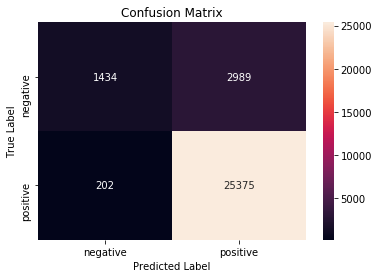

In [20]:
train_err_XG_tfidf,test_err_XG_tfidf,model_XG_tfidf = Run_XGBoostDT(X_train_tfidf, y_train,X_test_tfidf,y_test,basemodelcount_XG_tfidf, max_depth_XG_tfidf)

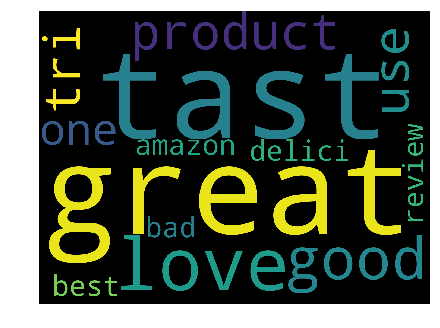

In [21]:
feature_importance(model_XG_tfidf,tfidf.get_feature_names())

# AvgW2V

In [22]:
with open('C:/Users/U6069188/Python Projects/Pickle/AvgW2V','rb') as f:
    AvgW2V = pickle.load(f)

In [23]:
# Loading 250 pts obtained after data preprocessing and sorting 

with open('C:/Users/U6069188/Python Projects/Pickle/FilteredData_250K','rb') as f:
    FilteredData = pickle.load(f)

In [24]:
X = np.array(AvgW2V)
X = X[0:100000,]

In [25]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "positive":
        return 1
    else:
        return -1

FilteredData["Score"] = FilteredData["Score"].map(polarity)

FilteredData["Score"].value_counts()

 1    212075
-1     37925
Name: Score, dtype: int64

In [26]:
y = FilteredData['Score'].values

In [27]:
y = y[0:100000,]

In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.7)

In [29]:
X_train.shape

(70000, 50)

# RandomForestClassifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
('n_estimators', 90)


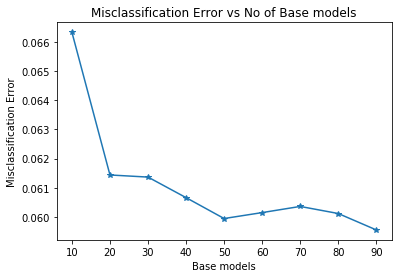

In [38]:
basemodelcount_RF_avgw2v = RunRandomForest_CV(X_train, y_train)

************************************************************************************************************************
Base Model count is 90
Accuracy is  89.55
Log loss: 0.26716
F1 score is  72.97
Recall is  68.24
Precision is  85.81

 Classification report is 
                precision    recall  f1-score   support

          -1       0.81      0.38      0.52      4435
           1       0.90      0.99      0.94     25565

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.86      0.68      0.73     30000
weighted avg       0.89      0.90      0.88     30000



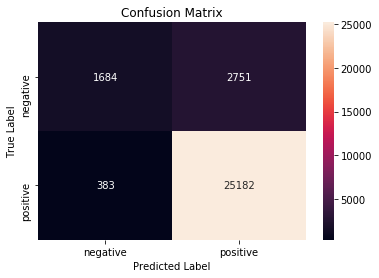

In [39]:
train_err_RF_avgw2v,test_err_RF_avgw2v,model_RF_avgw2v = Run_RandomForestDT(X_train, y_train,X_test,y_test,basemodelcount_RF_avgw2v)

# XGBoostClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


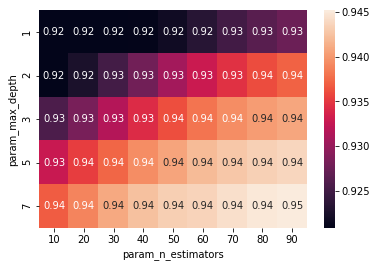

In [30]:
basemodelcount_XG_avgw2v, max_depth_XG_avgw2v = RunXGBoost_CV(X_train, y_train)

************************************************************************************************************************
Base Model count is 90
Accuracy is  90.2
Log loss: 0.23845
F1 score is  77.74
Recall is  74.03
Precision is  84.12

 Classification report is 
                precision    recall  f1-score   support

          -1       0.76      0.51      0.61      4539
           1       0.92      0.97      0.94     25461

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.89      0.90      0.89     30000



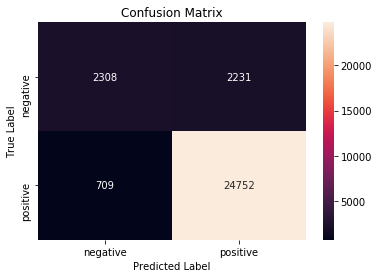

In [31]:
train_err_XG_avgw2v,test_err_XG_avgw2v,model_XG_avgw2v = Run_XGBoostDT(X_train, y_train,X_test,y_test,basemodelcount_XG_avgw2v, max_depth_XG_avgw2v)

# TFIDFW2V

In [32]:
with open('C:/Users/U6069188/Python Projects/Pickle/tfidf_sent_vectors','rb') as f:
    tfidf_sent_vectors = pickle.load(f)

In [33]:
X = np.array(tfidf_sent_vectors)
X = X[0:100000,]

In [34]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.7)

# RandomForestClassifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
('n_estimators', 80)


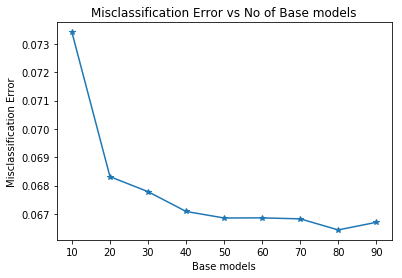

In [43]:
basemodelcount_RF_tfidfw2v = RunRandomForest_CV(X_train, y_train)

************************************************************************************************************************
Base Model count is 80
Accuracy is  87.94
Log loss: 0.30023
F1 score is  66.02
Recall is  62.28
Precision is  82.48

 Classification report is 
                precision    recall  f1-score   support

          -1       0.76      0.26      0.39      4407
           1       0.89      0.99      0.93     25593

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.82      0.62      0.66     30000
weighted avg       0.87      0.88      0.85     30000



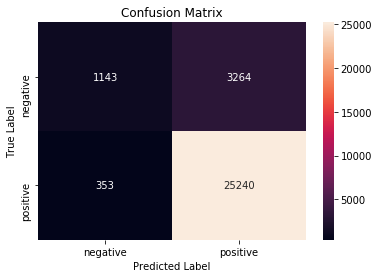

In [44]:
train_err_RF_tfidfw2v,test_err_RF_tfidfw2v,model_RF_tfidfw2v = Run_RandomForestDT(X_train, y_train,X_test,y_test,basemodelcount_RF_tfidfw2v)

# XGBoostClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


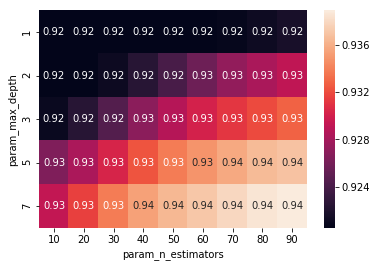

In [35]:
basemodelcount_XG_tfidfw2v, max_depth_XG_tfidfw2v = RunXGBoost_CV(X_train, y_train)

************************************************************************************************************************
Base Model count is 90
Accuracy is  89.18
Log loss: 0.26271
F1 score is  73.69
Recall is  69.56
Precision is  82.82

 Classification report is 
                precision    recall  f1-score   support

          -1       0.75      0.42      0.54      4498
           1       0.90      0.98      0.94     25502

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.83      0.70      0.74     30000
weighted avg       0.88      0.89      0.88     30000



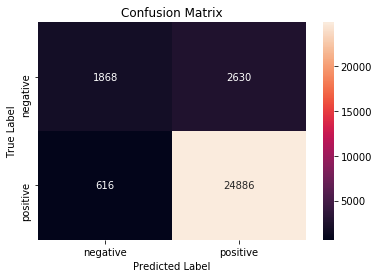

In [36]:
train_err_XG_tfidfw2v,test_err_XG_tfidfw2v,model_XG_tfidfw2v = Run_XGBoostDT(X_train, y_train,X_test,y_test,basemodelcount_XG_tfidfw2v, max_depth_XG_tfidfw2v)

In [45]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [46]:
x.field_names = ["Model", "No of base models", "Train Error", "Test Error"]

In [47]:
x.add_row(["Random Forest For Bow",basemodelcount_RF_bow, train_err_RF_bow*100,101+test_err_RF_bow])
x.add_row(["Random Forest For TfIdf",basemodelcount_RF_tfidf, train_err_RF_tfidf*100,101+test_err_RF_tfidf])
x.add_row(["Random Forest For AvgW2V",basemodelcount_RF_avgw2v,train_err_RF_avgw2v*100,101+test_err_RF_avgw2v])
x.add_row(["Random Forest For tfidfW2V",basemodelcount_RF_tfidfw2v, train_err_RF_tfidfw2v*100,101+test_err_RF_tfidfw2v])

In [48]:
print(x)

+----------------------------+-------------------+-----------------------+--------------------+
|           Model            | No of base models |      Train Error      |     Test Error     |
+----------------------------+-------------------+-----------------------+--------------------+
|   Random Forest For Bow    |         30        |  0.03714285714285781  | 13.719999999999999 |
|  Random Forest For TfIdf   |         10        |   0.4242857142857104  |       13.39        |
|  Random Forest For AvgW2V  |         90        | 0.0014285714285744433 | 12.446666666666673 |
| Random Forest For tfidfW2V |         80        | 0.0028571428571377844 | 14.056666666666672 |
+----------------------------+-------------------+-----------------------+--------------------+


In [45]:
from prettytable import PrettyTable
    
y = PrettyTable()

In [46]:
y.field_names = ["Model", "No of base models", "Train Error", "Test Error"]

In [47]:
y.add_row(["XGBoost For Bow",basemodelcount_XG_bow, train_err_XG_bow*100,101+test_err_XG_bow])
y.add_row(["XGBoost For TfIdf",basemodelcount_XG_tfidf, train_err_XG_tfidf*100,101+test_err_XG_tfidf])
y.add_row(["XGBoost For AvgW2V",basemodelcount_XG_avgw2v,train_err_XG_avgw2v*100,101+test_err_XG_avgw2v])
y.add_row(["XGBoost For tfidfW2V",basemodelcount_XG_tfidfw2v, train_err_XG_tfidfw2v*100,101+test_err_XG_tfidfw2v])

In [48]:
print(y)

+----------------------+-------------------+-------------------+--------------------+
|        Model         | No of base models |    Train Error    |     Test Error     |
+----------------------+-------------------+-------------------+--------------------+
|   XGBoost For Bow    |         90        |     4.3456789     |   11.83435678998   |
|  XGBoost For TfIdf   |         90        | 9.124285714285719 | 12.63666666666667  |
|  XGBoost For AvgW2V  |         90        | 5.924285714285715 | 11.799999999999997 |
| XGBoost For tfidfW2V |         90        | 6.720000000000004 | 12.819999999999993 |
+----------------------+-------------------+-------------------+--------------------+


# Obseravtions:
Becuase of memory issue I have considered 100K points each for Random Forest and XGBoost.
1. Test error is almost same but little better for AvgW2V vectorizer.
2. Test error is almost same but little better for AvgW2V vectorizer.
Both for random forest and XGBoost AvgW2V is performing slightly better comparatively.